### Code to scrape images from google


from google_images_download import google_images_download   #importing the library
response = google_images_download.googleimagesdownload()    #class instantiation
arguments = {"keywords":"Dalai Lama,Martin Luther King Jr,Mahatma Gandhi,Nelson Mandela,Swami Vivekananda,Woodrow Wilson,Winston Churchill,Mother Teresa,"
                 ,"limit":20,"print_urls":True}                 #creating list of arguments
paths = response.download(arguments)                        #passing the arguments to the function
print(paths)                                                #printing absolute paths of the downloaded images


### Multiclass Classification

In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse, random, pickle, cv2, os, matplotlib
import mlflow
import mlflow.keras

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator()
data    = []
labels  = []

/Users/home/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


### Change your path to downloaded directory where images are scraped

In [3]:
imagePaths = sorted(list(paths.list_images('/Users/home/Desktop/Notes/Deep Learning/downloads')))
random.seed(42)
random.shuffle(imagePaths)

In [4]:
for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (64, 64))
	data.append(image)    
	datagen.apply_transform(image,{'theta':35,'shear':35,'zx':0.4,'zy':0.4})
	datagen.apply_transform(image,{'zoom_rage':0.4,'rotation_range' : 50})
	data.append(image)
	datagen.apply_transform(image,{'theta':10,'shear':10,'zx':0.2,'zy':0.2})
	datagen.apply_transform(image,{'flip_horizontal':True})
	datagen.apply_transform(image,{'zoom_rage':0.2})
	data.append(image)
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)
	labels.append(label)
	labels.append(label)

In [5]:
len(data),len(labels)

(474, 474)

In [6]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.30, random_state=42)

In [8]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

### Sliced VGG Architecture

In [9]:
model = Sequential()
model.add(ZeroPadding2D((4,4),input_shape=(64,64,3)))

model.add(Convolution2D(64,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(512,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, input_shape=(4096,), activation="relu", kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(len(lb.classes_), activation="softmax", kernel_constraint=maxnorm(3)))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/home/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 128)       0         
__________

In [10]:
BS = 32
EPOCHS = 90
print("[INFO] training network.....")
sgd = SGD(lr=0.007, decay=1e-6, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

[INFO] training network.....


In [11]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),  epochs=EPOCHS,   batch_size=BS)


Instructions for updating:
Use tf.cast instead.
Train on 331 samples, validate on 143 samples
Epoch 1/90
331/331 [==============================] - 12s 35ms/step - loss: 2.3309 - acc: 0.1329 - val_loss: 2.0388 - val_acc: 0.2308
Epoch 2/90
331/331 [==============================] - 11s 33ms/step - loss: 2.1446 - acc: 0.1480 - val_loss: 2.0353 - val_acc: 0.2308
Epoch 3/90
331/331 [==============================] - 11s 34ms/step - loss: 2.0076 - acc: 0.2115 - val_loss: 1.9918 - val_acc: 0.3007
Epoch 4/90
331/331 [==============================] - 11s 33ms/step - loss: 1.8895 - acc: 0.2810 - val_loss: 1.9487 - val_acc: 0.3427
Epoch 5/90
331/331 [==============================] - 11s 33ms/step - loss: 1.8558 - acc: 0.2810 - val_loss: 1.8602 - val_acc: 0.4126
Epoch 6/90
331/331 [==============================] - 11s 33ms/step - loss: 1.7298 - acc: 0.3051 - val_loss: 1.8205 - val_acc: 0.3566
Epoch 7/90
331/331 [==============================] - 11s 33ms/step - loss: 1.6484 - acc: 0.3837 - val

In [12]:
with mlflow.start_run():
    for n in range(0,len(H.history["loss"])):        
        mlflow.log_metric("training_loss", H.history["loss"][n])
        mlflow.log_metric("training_acc", H.history["acc"][n])
        mlflow.log_metric("validation_loss", H.history["val_loss"][n])
        mlflow.log_metric("validation_acc", H.history["val_acc"][n])
        # log artifacts
        mlflow.log_artifacts('/Users/home/Desktop/Notes/Deep Learning/downloads', "images")
   # log model
mlflow.keras.log_model(model, "models")

[INFO] evaluating network...
                       precision    recall  f1-score   support

           Dalai Lama       0.74      1.00      0.85        17
       Mahatma Gandhi       0.69      0.69      0.69        16
Martin Luther King Jr       0.95      1.00      0.98        20
        Mother Teresa       1.00      0.57      0.73        21
       Nelson Mandela       0.55      1.00      0.71        16
    Swami Vivekananda       1.00      0.41      0.58        17
    Winston Churchill       1.00      0.89      0.94        18
       Woodrow Wilson       0.95      1.00      0.97        18

             accuracy                           0.82       143
            macro avg       0.86      0.82      0.81       143
         weighted avg       0.87      0.82      0.81       143



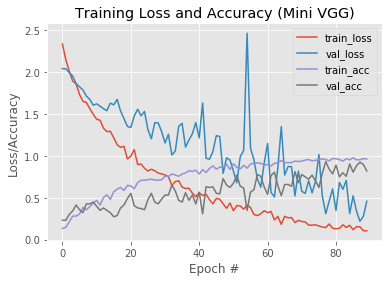

In [13]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Mini VGG)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()